# Load Data & Split

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from glob import glob

base_path = "/kaggle/input/leapgestrecog/leapGestRecog"

assert os.path.exists(base_path)

subjects = sorted([s for s in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, s))])
print("Total subjects:", len(subjects))

train_subj, test_subj = train_test_split(subjects, test_size=0.2, random_state=42)
print("Train subjects:", train_subj)
print("Test subjects:", test_subj)


2025-11-29 22:39:38.441831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764455978.638173      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764455978.697942      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Total subjects: 10
Train subjects: ['05', '00', '07', '02', '09', '04', '03', '06']
Test subjects: ['08', '01']


In [2]:
target_dir = "gesture_data_full"
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
os.makedirs(os.path.join(target_dir, "train"))
os.makedirs(os.path.join(target_dir, "test"))

def copy_subjects(subj_list, subset):
    for subj in subj_list:
        subj_path = os.path.join(base_path, subj)
        for gesture in os.listdir(subj_path):
            src_dir = os.path.join(subj_path, gesture)
            dst_dir = os.path.join(target_dir, subset, gesture)
            os.makedirs(dst_dir, exist_ok=True)
            for img_name in os.listdir(src_dir):
                shutil.copy(os.path.join(src_dir, img_name), os.path.join(dst_dir, img_name))

copy_subjects(train_subj, "train")
copy_subjects(test_subj, "test")

print(" Data folders prepared under:", target_dir)


 Data folders prepared under: gesture_data_full


# Data Augmentation

In [3]:
img_size = (128, 128)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,           
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,
    brightness_range=[0.7, 1.3], 
    channel_shift_range=20.0,   
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(target_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(target_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [4]:
num_classes = 10

# Build Custom_CNN Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Block 1
    Conv2D(64, (3,3), activation='relu', padding='same', 
           kernel_regularizer=l2(0.001), input_shape=(*img_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Block 2
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    
    # Block 3
    Conv2D(256, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),
    
    # Block 4
    Conv2D(512, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.5),
    
    GlobalAveragePooling2D(),
    
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(num_classes, activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764457086.241818      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,02

 Total params: 1,954,442 (7.46 MB)

 Trainable params: 1,950,986 (7.44 MB)

 Non-trainable params: 3,456 (13.50 KB)

# Compile Model

In [6]:
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_gesture_full.keras", save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-7, verbose=1)
]

# Class Weight

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight_dict = dict(enumerate(class_weights))


# Train the Model

In [9]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=40,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1764457095.053635     146 service.cc:148] XLA service 0x78a9f8019720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764457095.054409     146 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764457095.851012     146 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/500 ━━━━━━━━━━━━━━━━━━━━ 2:18:50 17s/step - accuracy: 0.0312 - loss: 5.2047

I0000 00:00:1764457104.784939     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.1720 - loss: 4.2503
Epoch 1: val_loss improved from inf to 5.17950, saving model to best_gesture_full.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 227ms/step - accuracy: 0.1722 - loss: 4.2492 - val_accuracy: 0.1000 - val_loss: 5.1795 - learning_rate: 5.0000e-04
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6833 - loss: 2.2448
Epoch 2: val_loss improved from 5.17950 to 2.52577, saving model to best_gesture_full.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 221ms/step - accuracy: 0.6834 - loss: 2.2443 - val_accuracy: 0.6488 - val_loss: 2.5258 - learning_rate: 5.0000e-04
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8829 - loss: 1.5777
Epoch 3: val_loss improved from 2.52577 to 1.89536, saving model to best_gesture_full.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 110s 219ms/step - accuracy: 0.8829 - loss: 1.5775 - val_accuracy: 0.7550 - val_loss: 1.8954 - learning_rate: 5.0000e-04
Epoch 4/40
500/500 ━━━━━━━━━

# Evaluation on Test Set

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9812 - loss: 0.2956

Test Accuracy: 98.93%
Test Loss: 0.2350
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       400
         02_l       1.00      0.90      0.95       400
      03_fist       0.96      0.99      0.98       400
04_fist_moved       0.98      1.00      0.99       400
     05_thumb       1.00      1.00      1.00       400
     06_index       0.96      1.00      0.98       400
        07_ok       1.00      1.00      1.00       400
08_palm_moved       1.00      1.00      1.00       400
         09_c       1.00      1.00      1.00       400
      10_down       1.00      1.00      1.00       400

     accuracy                           0.99      4000
    macro avg       0.99      0.99      0.99      4000
 weighted avg       0.99      0.99      0.99      4000



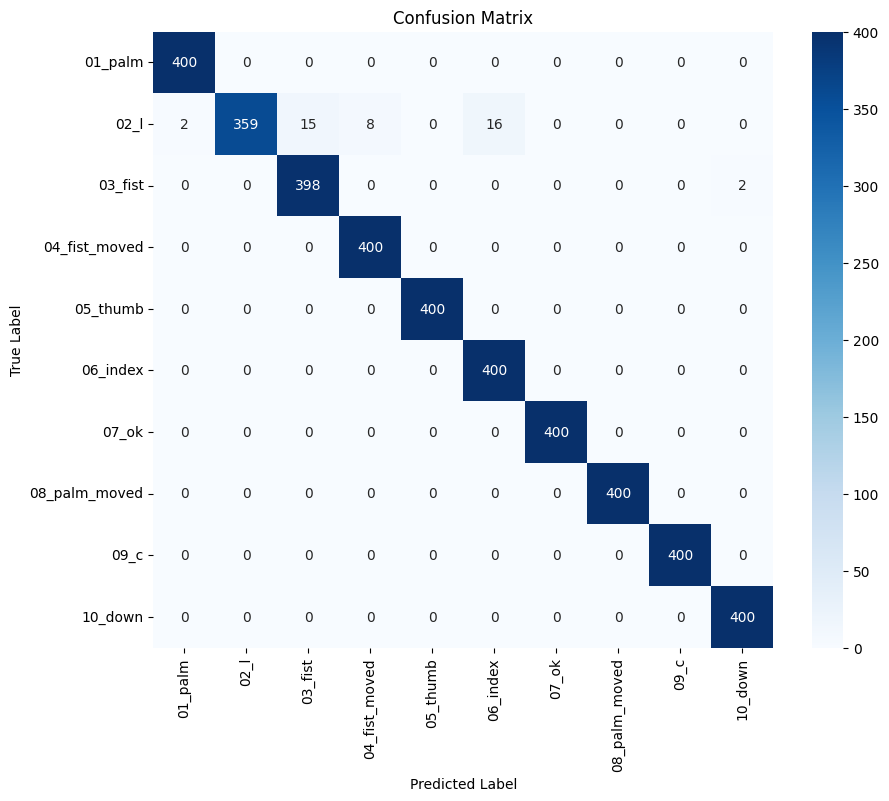

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


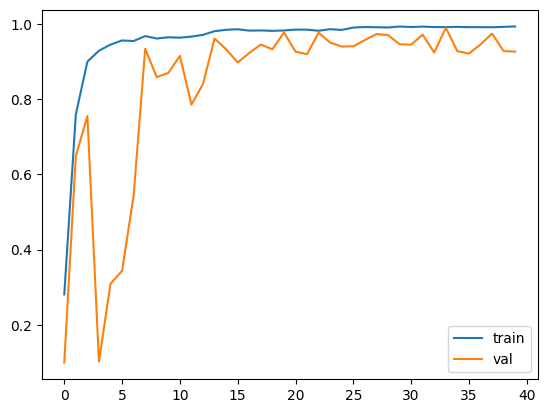

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.show()

# Plot Training Curves (Accuracy & Loss)

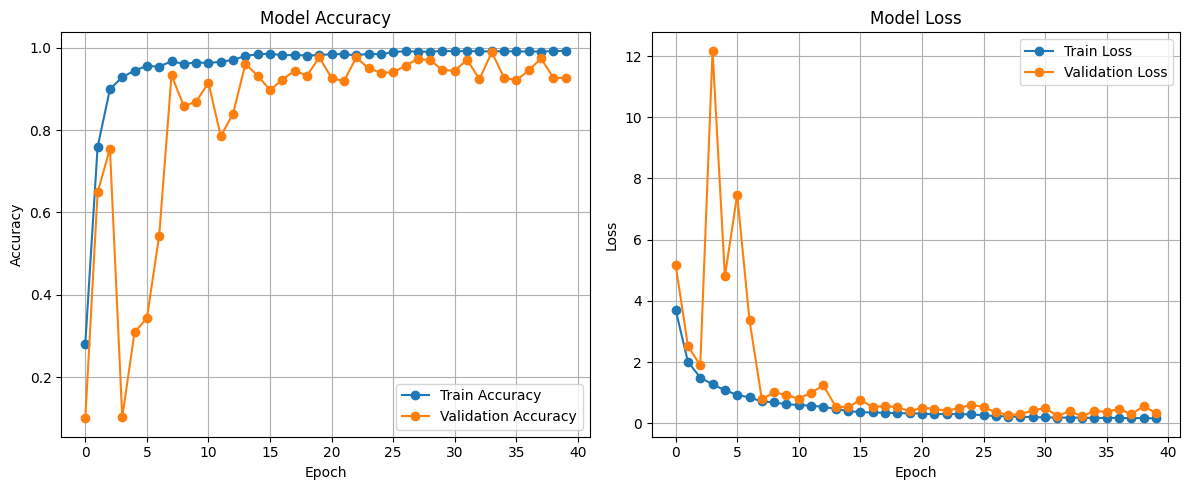

In [19]:
import matplotlib.pyplot as plt

#  Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#  Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
import pickle

with open('history_mymodel.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [21]:
model.save('my_model.h5')